In [1]:

# univariate multi-step vector-output stacked lstm
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
 
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
# define input sequence
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# choose a number of time steps
n_steps_in, n_steps_out = 3, 2
# split into samples
X, y = split_sequence(raw_seq, n_steps_in, n_steps_out)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=50, verbose=0)
# demonstrate prediction
x_input = array([70, 80, 90])
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[120.04134 141.41809]]


In [2]:
# univariate multi-step encoder-decoder lstm example
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# define input sequence
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# choose a number of time steps
n_steps_in, n_steps_out = 3, 2
# split into samples
X, y = split_sequence(raw_seq, n_steps_in, n_steps_out)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
y = y.reshape((y.shape[0], y.shape[1], n_features))
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=100, verbose=0)
# demonstrate prediction
x_input = array([70, 80, 90])
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[[102.97651]
  [115.81972]]]


# **Implementation try 1.1 for ENCODER-DECODER LSTM**



In [4]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from google.colab import drive
drive.mount('/content/drive')

df=pd.read_csv("TSLA.csv")
print("Number of rows and columns:", df.shape)
print(df.isna().any())
df.head(25)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Number of rows and columns: (1259, 7)
Date         False
Open         False
High         False
Low          False
Close        False
Adj Close    False
Volume       False
dtype: bool


,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-07-10,52.444000,52.599998,51.563999,51.830002,51.830002,13054500
1,2015-07-13,52.450001,52.509998,51.209999,52.431999,52.431999,14801500
2,2015-07-14,52.419998,53.198002,52.102001,53.130001,53.130001,9538000
3,2015-07-15,53.348000,53.498001,52.416000,52.627998,52.627998,10108000
4,2015-07-16,52.844002,53.439999,52.632000,53.335999,53.335999,8080000
5,2015-07-17,54.500000,55.108002,53.650002,54.931999,54.931999,25020500
6,2015-07-20,55.000000,57.330002,54.507999,56.452000,56.452000,24892500
7,2015-07-21,54.009998,54.700001,53.310001,53.354000,53.354000,30543500
8,2015-07-22,52.254002,53.888000,52.172001,53.574001,53.574001,15525000
9,2015-07-23,53.930000,53.980000,53.054001,53.439999,53.439999,11136000


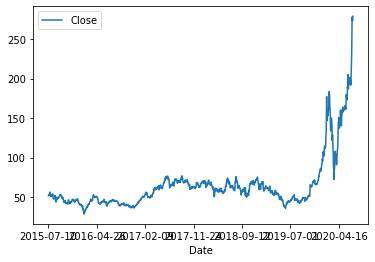

In [5]:
df.plot(x ='Date', y='Close', kind = 'line')
plt.show()

In [6]:
test_array = df["Close"].to_numpy()
test_array = test_array[:1250]
print(test_array)
print(test_array.shape)

[ 51.830002  52.431999  53.130001 ... 200.356003 192.169998 197.195999]
(1250,)


In [12]:
# univariate multi-step encoder-decoder lstm example
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# define input sequence
#raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# choose a number of time steps
n_steps_in, n_steps_out = 50, 10
# split into samples
X, y = split_sequence(test_array, n_steps_in, n_steps_out)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
y = y.reshape((y.shape[0], y.shape[1], n_features))

print(X.shape)
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(5)))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=10, verbose=0)
# demonstrate prediction
x_input = test_array
print(x_input)
x_input = x_input.reshape((25, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

(1191, 50, 1)
[ 51.830002  52.431999  53.130001 ... 200.356003 192.169998 197.195999]
[[[  74.88564     95.84057     70.02994     50.449593    50.27231  ]
  [  47.821987    81.10293     77.34462     81.499695    44.078957 ]
  [  53.64204     73.217186    68.11122     79.524216    42.28827  ]
  ...
  [  54.354618    71.090515    62.921616    79.2933      37.88329  ]
  [  54.234398    70.7631      62.425568    79.11353     37.298153 ]
  [  54.126957    70.470535    61.982105    78.95295     36.7751   ]]

 [[  19.624992    62.268246     9.161533    53.88563     63.98533  ]
  [  39.17755     63.419025    80.84762     63.539474    74.91107  ]
  [  40.674465    53.177433    69.87631     58.921444    78.913795 ]
  ...
  [  40.496788    53.41808     69.14479     59.396046    78.43708  ]
  [  40.49679     53.418026    69.144936    59.39596     78.437164 ]
  [  40.496796    53.418037    69.14491     59.395973    78.43715  ]]

 [[  93.15966     64.95747     86.92908     53.92309    107.39229  ]
 